### Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow            as tf
import tensorflow.keras      as keras
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.layers import (
    MaxPooling2D,
    AvgPool2D,
    Input,
    InputLayer,
    Dropout,
    Flatten,
    Dense,
    Lambda,
    Add
)
from tensorflow.keras.applications import vgg19
import matplotlib.pyplot     as plt
import pandas                as pd

import skimage
import skimage.transform
import numpy as np

In [36]:
import sys
sys.path.append('../utilities/')
from utilities import (
    Timer,
    show_image,
    vgg19_process_image,
    class_names,
    Source,
    get_image_from_model,
    load_image,
    precomputed_loss
)

### Setup

In [4]:
width = height = 224

In [5]:
# Load the model
# model_name = 'vgg19-INet-down2-b'
# base_model = load_model(f'../classification/logs/models/{model_name}.hdf5')
base_model = vgg19.VGG19(include_top = True, weights = 'imagenet')
base_model.trainable = False

### Unconstrained VGG19 Dream

In [64]:
input_ = Input(shape = (), batch_size = 1)

image_layer  = Source((1, width, height, 3), name = 'image')

signal = image_layer(input_)

output_layers = {
    'block5_pool' : 1.0
}

outputs = []
def get_summary_function(weight):
    def summary_fn(activation):
        activation = tf.square(activation)
        axes       = tf.range(1, tf.rank(activation))
        activation = tf.reduce_mean(activation, axis = axes)
        return activation * (-1) * weight
    return summary_fn

for layer in base_model.layers[1:]:
    signal = layer(signal)
    if layer.name in output_layers:
        summarizer_layer = Lambda(get_summary_function(output_layers[layer.name]))
        total_activation = summarizer_layer(signal)
        outputs.append(total_activation)
        
if len(outputs) == 1:
    final_output = outputs[0]
else:
    final_output = Add()(outputs)
    

model = Model(inputs = input_, outputs = final_output)

In [65]:
# Load the image
image_path = '../dream-base-images/marco3.png'
image = load_image(image_path, cast = tf.float32)
image = tf.image.resize(image, [width, height])
image = vgg19_process_image(image)
image = tf.expand_dims(image, axis = 0)
image_layer.set_weights([image.numpy()])

In [66]:
dummy       = tf.constant(0, shape = (1,), dtype = tf.float32)
dummy_input = tf.data.Dataset.from_tensors((dummy, dummy))

In [ ]:
adam = tf.optimizers.Adam(learning_rate = 1.0)
model.compile(optimizer = adam, loss = precomputed_loss)
history = model.fit(dummy_input.repeat(100), epochs = 3)

In [39]:
from tensorflow.keras.utils import plot_model

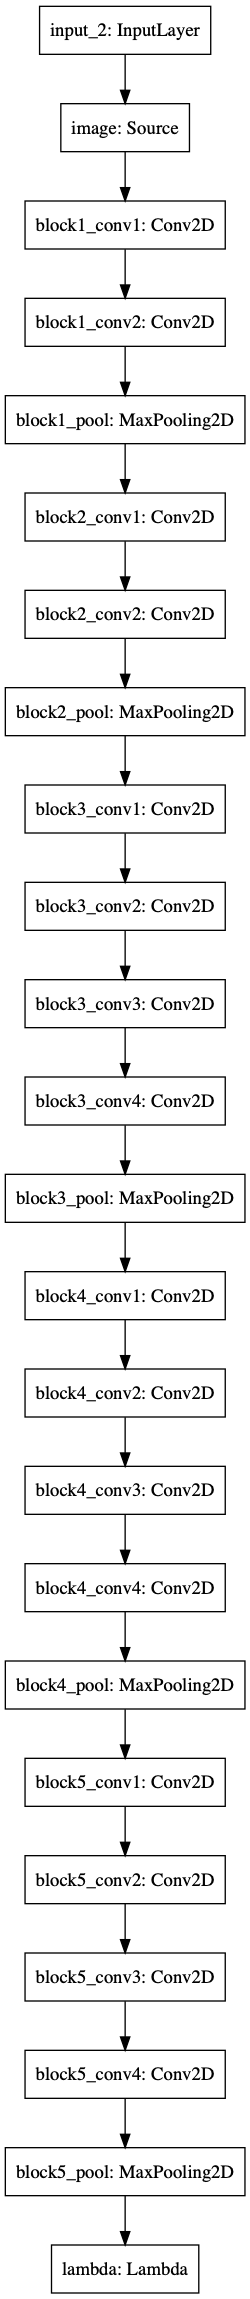

In [40]:
plot_model(model)

In [ ]:
# dream_model = Sequential([InputLayer(input_shape = (width, height, 3))])
# for layer in base_model.layers[:-1]:
#     # Replace max pool with average pool to promote gradient flow
#     if isinstance(layer, MaxPooling2D):
#         pool = AvgPool2D().from_config(layer.get_config())
#         dream_model.add(pool)
#     elif isinstance(layer, Dropout):
#         pass
#     else:
#         dream_model.add(layer)
    
# # Add the top layer without softmax
# top_config = base_model.layers[-1].get_config()
# top_config['activation'] = 'elu'
# top_layer = base_model.layers[-1].from_config(top_config)
# dream_model.add(top_layer)
# dream_model.build()
# top_layer.set_weights(base_model.layers[-1].get_weights())